In [ ]:
from google.colab import files
 
 
data = files.upload()


KeyboardInterrupt: ignored

In [13]:
!pip install pandas
!pip install tensorflow


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
data = pd.read_csv("preprocessed_data.csv")

In [4]:
print(data.columns)

Index(['uniqueID', 'drugName', 'condition', 'review', 'usefulCount', 'Rating',
       'year', 'month', 'day'],
      dtype='object')


In [5]:
print(data.shape)

(159498, 9)


In [6]:
print(data['Rating'].value_counts())

1    112003
0     47495
Name: Rating, dtype: int64


In [7]:
print(data.head(2))

   uniqueID    drugName                     condition  \
0    206461   valsartan  left ventricular dysfunction   
1     95260  guanfacine                          adhd   

                                              review  usefulCount  Rating  \
0  side effect take combination bystolic 5 mg fis...           27       1   
1  son halfway fourth week intuniv became concern...          192       1   

   year  month  day  
0  2012      5   20  
1  2010      4   27  


In [8]:
x = data.drop(['Rating'],axis=1)
y = data['Rating']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=42)
y_test.shape

(31900,)

In [20]:

from imblearn.over_sampling import SMOTE


#from sklearn.utils.metaestimators import available_if
ros =SMOTE(random_state=777)
X_train, y_train = ros.fit_resample(X_train, y_train)

ModuleNotFoundError: No module named 'imblearn'

In [22]:
print(X_train.shape,X_test.shape)

(127598, 8) (31900, 8)


In [23]:
import pickle
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['review'].values.astype('U'))
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [24]:
train_review = vectorizer.transform(X_train['review'].values.astype('U'))
test_review = vectorizer.transform(X_test['review'].values.astype('U'))
test_review.shape

(31900, 46381)

In [25]:
model = LogisticRegression()

In [ ]:
space = dict()

space['penalty'] = ['l1', 'l2']
space['C'] = loguniform(1e-5, 10)
cv = 3

In [ ]:
search = RandomizedSearchCV(model, space, n_iter=100, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

In [ ]:
result = search.fit(train_review, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8427718229510788
Best Hyperparameters: {'C': 6.450144652189367, 'penalty': 'l2'}


In [ ]:
model = LogisticRegression(C=6.450144652189367,penalty= 'l2')
model.fit(train_review, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=6.450144652189367)

In [ ]:
y_pred = model.predict(test_review)
print(y_pred.shape)

(31900,)


Test confusion matrix


Text(33.0, 0.5, 'Actual label')

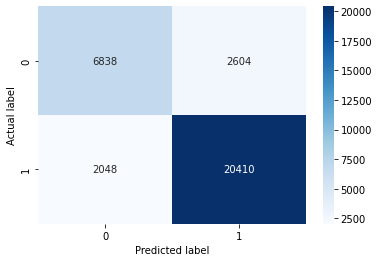

In [ ]:
print("Test confusion matrix")

cntestlog = confusion_matrix(y_test,y_pred)
sns.heatmap(cntestlog, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [ ]:
#Accuracy of the model
Accuracy = (cntestlog[0][0] + cntestlog[1][1]) / (cntestlog[0][0] + cntestlog[1][1] + cntestlog[0][1] + cntestlog[1][0])
print("Accuracy log test",Accuracy)

Accuracy log test 0.8541692789968652


Train confusion matrix


Text(33.0, 0.5, 'Actual label')

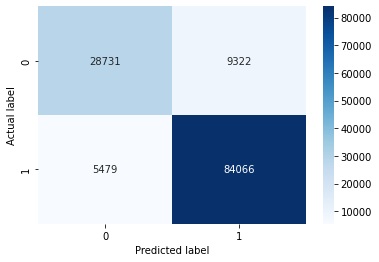

In [ ]:
ytrainpred = model.predict(train_review)
print("Train confusion matrix")
#plot confusion matrix
cnlogtrain = confusion_matrix(y_train,ytrainpred)
sns.heatmap(cnlogtrain, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [ ]:
Accuracy = (cnlogtrain[0][0] + cnlogtrain[1][1]) / (cnlogtrain[0][0] + cnlogtrain[1][1] + cnlogtrain[0][1] + cnlogtrain[1][0])
print("Accuracy log train",Accuracy)

Accuracy log train 0.8840028840577439


roc auc score = 0.9021821835082999


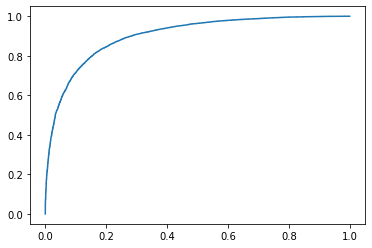

In [ ]:
y_pred_proba = model.predict_proba(test_review)[:, 1]
print(f"roc auc score = {roc_auc_score(y_test, y_pred_proba)}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr)

**Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier()
# parameters dict
params = {
    'max_depth' : [1, 3, 10, 30,45],
    'min_samples_split' : [5, 10, 100, 500,1000],
    "min_samples_leaf": [1,3,4,5,6,7],
    "criterion": ["gini", "entropy"]
}
#Randomsearch
clf = RandomizedSearchCV(model,params,cv=3,scoring='roc_auc',return_train_score=True)
clf.fit(train_review, y_train)



max_depth = clf.cv_results_['param_max_depth']
#best parameter
best_para = clf.best_params_
print(best_para)

{'min_samples_split': 1000, 'min_samples_leaf': 5, 'max_depth': 45, 'criterion': 'entropy'}


In [ ]:
min_sample = clf.best_params_['min_samples_split']
min_sample =  clf.best_params_['min_samples_split']
max_depth = clf.best_params_['max_depth']
criter =  clf.best_params_['criterion']

Test confusion matrix


Text(33.0, 0.5, 'Actual label')

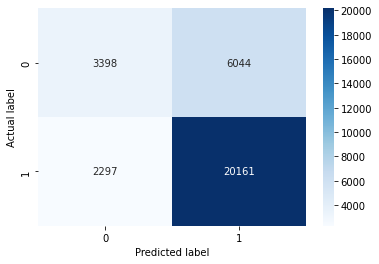

In [ ]:
#training model with best parameters found using randomsearch
clfnewd = DecisionTreeClassifier(min_samples_split = min_sample,min_samples_leaf=min_sample,max_depth=max_depth,criterion=criter)
clfnewd.fit(train_review, y_train)
#Presicting values for test samples
ydpred = clfnewd.predict(test_review)
print("Test confusion matrix")
#Plot confusion matrix
cn2 = confusion_matrix(y_test,ydpred)
sns.heatmap(cn2, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [ ]:
#Accuracy of model test
Accuracy = (cn2[0][0] + cn2[1][1]) / (cn2[0][0] + cn2[1][1] + cn2[0][1] + cn2[1][0])
print("Accuracy",Accuracy)

Accuracy 0.7385266457680251


Train confusion matrix


Text(33.0, 0.5, 'Actual label')

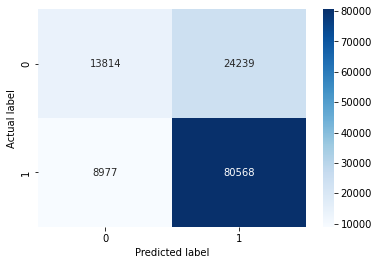

In [ ]:
ytrainpred = clfnewd.predict(train_review)
print("Train confusion matrix")
#Plot confusion matrix for Train samples
cn3 = confusion_matrix(y_train,ytrainpred)
sns.heatmap(cn3, annot=True,fmt="d",cmap='Blues')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [ ]:
#Accuracy of model train
Accuracy = (cn3[0][0] + cn3[1][1]) / (cn3[0][0] + cn3[1][1] + cn3[0][1] + cn3[1][0])
print("Accuracy",Accuracy)

Accuracy 0.7396824401636389


roc auc score = 0.7408778789578057


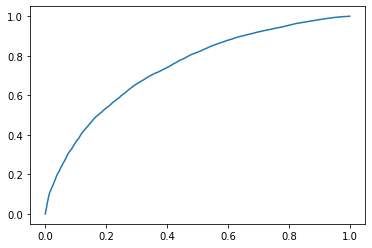

In [ ]:
y_pred_proba = clfnewd.predict_proba(test_review)[:, 1]
print(f"roc auc score = {roc_auc_score(y_test, y_pred_proba)}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr)

####  Naive Bayes 
